# Determining Rainfall Intensity/Duration/Frequency Parameters for a Site

Below we provide a method for utilizing site-specific Rainfall Intensity and Frequency data available from NOAA's **Precipitation Frequency Data Server** web site at https://hdsc.nws.noaa.gov/hdsc/pfds/index.html to generate Rainfall Intensity/Duration/Frequency plots.  We also derive fitted parameters for estimating the rainfall intensity-duration-frequency (IDF) relationship (power-law model) from this site-specific data.

In the example below, we use data downloaded from NOAA for Sacramento, California to determine the design rainfall intensity for a runoff management structure at the drainage point of a basin. This data provides rainfall inte|nsities for a site organized by duration of the precipitation event and frequency of occurance (expressed as an Annual Recurrance Interval). We present a strategy for estimating parameters for the Rainfall Intensity equation below.

## Step 1. Examine Rainfall Intensity/Duration/Frequency Data for the Site

We assume the data for the site in question (in the example below, for Sacramento, CA) has been downloaded from the NOAA Precipitation Frequency Data Server described above and is available for processing.  We employ a Python script to examine the data.  

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets


def TimeStrToMinutes(timeStr):
    [duration,unit] = timeStr.split('-')
    duration = int(duration)
    if unit == 'min:':
        return duration
    elif unit == 'hr:':
        return duration*60
    elif unit == 'day:':
        return duration*60*24
    return None

df = pd.read_csv( 'Datasets/PF_Intensity_Metric_PDS.csv', skiprows=13,skipfooter=3,engine='python')

lastRow = 8   # last row to plot 

durations = df['by duration for ARI (years):'][:lastRow]        # '5-min', '10-min' etc
minutes = [TimeStrToMinutes(timeStr) for timeStr in durations]  # convert to integer minutes
ARIs = list(df.columns)[1:]                                     # annual return interval (years)


#from scipy.interpolate import make_interp_spline, BSpline
#xnew = np.linspace(1,df.index.stop, 100) 
#spl = make_interp_spline(T, power, k=3)  # type: BSpline
#power_smooth = spl(xnew)
right = widgets.Output()
left = widgets.Output()

with left:
    display(HTML(df.to_html(index=False)))
    

with right:
    plt.figure(figsize=(6,8))
    plt.plot(minutes,df.iloc[:lastRow,1:].values)
    plt.xlabel("Duration (minutes)",fontsize=18)
    plt.ylabel("Rainfail Intensity (mm/hr)", fontsize=18)
    plt.legend(ARIs, title="Recurrence\nInterval\n(years)", fontsize=14)
    plt.title("Rainfall\nIntensity-Duration-Frequency\nCurves", fontsize=20)
    plt.grid()
    plt.show()

widgets.HBox([left, right])

## Step 2.  Determine Design Rainfall Intensity 

When designing hydraulic control structures, a useful design parameter is the **Rainfall Intensity** for which the deign must be able to handle. The Rainfall Intensity is the average loction-specific rainfall rate for a specified duration and frequency (annual recurrance interval), and is specified on the chart above for a given precipitation event duration and frequency. In many cases, site-specific data such as the table and chart above are sufficient for determining the design Rainfall Intensity, once 1) the appropriate duration (corresponding to the **Time of Concentration** $\large t_c$), and 2) the design frequency (annual recurrance interval) appropriate to the design requirements has been determined.

The **time of concentration $\large (t_c$)** is a measure of the time required for an entire watershed to contribute to runoff at the point of in a watershed, calculated as the time for runoff to flow from the most hydraulically remote point of the drainage area to the point under investigation using a variety of methods descmethods described [here](Time%20of%20Concentration.ipynb). The **time of concentration** corresponds to the "duration" axis on the chart above.

For more precise determination for locations "between" entries in the table above, we can estimate rainfall intensity by fitting the desired intensity/duration curve corresponding to the desired design frequency to the data in the table above using the following relationship:

$\displaystyle \large I = \frac{b}{(t_c+d)^e} $

where $\large e$, $\large b$ and $\large d$ are location specific parameters, derived from an analysis of rainfall data.

### Estimating Site-specific Parameters for the Rainfall Intensity Equation from NOAA Data

We Python code to generate site-specific Rainfall Intensity parameters and in use those parameters to compute  a design Rainfall Intensity for a given duration (Time of Concentration) and frequency (annual return interval)

Fitted Parameters: e=0.550, b=118.779, d=0.8
Design Rainfall Intensity for Time of Concentration of 35 is 16.6


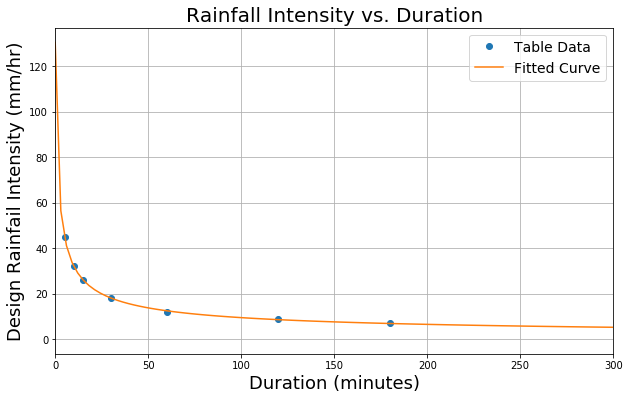

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def RainfallIntensity(tc,e,b,d):
    return b/np.power((tc + d),e)


ARI = '2'
df = pd.read_csv( 'Datasets/PF_Intensity_Metric_PDS.csv', skiprows=13,skipfooter=3,engine='python')
durations = df['by duration for ARI (years):']                  # '5-min', '10-min' etc
minutes = [TimeStrToMinutes(timeStr) for timeStr in durations]  # convert to integer minutes
rainIntensities = df[ARI]

[e,b,d],_ = curve_fit(RainfallIntensity, minutes, rainIntensities, [.5,100,1])
print( "Fitted Parameters: e={:.3f}, b={:.3f}, d={:.1f}".format(e,b,d))

# compute rainfall intesity for a specific duration (tc)
timeOfConc = 35  # minutes
designRI = RainfallIntensity(timeOfConc,e,b,d)
print( "Design Rainfall Intensity for Time of Concentration of {} is {:.1f}".format(timeOfConc,designRI))

plt.figure(figsize=(10,6))
plt.plot( minutes, rainIntensities, 'o', label="Table Data")
x = np.linspace(0,300,100)
plt.plot(x, RainfallIntensity(x,e,b,d), label="Fitted Curve")
plt.xlim(0,300)
plt.xlabel("Duration (minutes)",fontsize=18)
plt.ylabel("Design Rainfail Intensity (mm/hr)", fontsize=18)
plt.legend(fontsize=14)
plt.title("Rainfall Intensity vs. Duration", fontsize=20)
plt.grid()
plt.show()